# Lab 06 - Fraud Detection

---
embed-resources: true
---

## Introduction

In this lab, we will be looking at credit card information to create an automated fraud detector. This model will immediately identify the transaction as fraudulent or genuine.

## Methods

In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    fbeta_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.metrics import confusion_matrix

### Data

In [2]:
# load data
fraud_train = pd.read_parquet(
    "https://cs307.org/lab/data/fraud-train.parquet",
)
fraud_test = pd.read_parquet(
    "https://cs307.org/lab/data/fraud-test.parquet",
)
# create X and y for train
X_train = fraud_train.drop("Fraud", axis=1)
y_train = fraud_train["Fraud"]

# create X and y for test
X_test = fraud_test.drop("Fraud", axis=1)
y_test = fraud_test["Fraud"]

In [3]:
# summary statistics
fraud_train

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,Amount,Fraud
137250,-0.514509,0.899378,1.627215,-0.142250,0.005250,-0.235422,0.482540,0.247403,-0.562327,-0.166813,...,-0.143290,-0.390205,0.030719,0.184779,-0.348711,0.073253,0.273217,0.107938,3.59,0
132979,-0.813568,-0.373893,1.152977,-0.449774,-3.868866,2.780636,3.654192,-0.672442,0.753230,-0.662803,...,-0.376783,-0.004239,0.074801,0.124238,-0.448493,0.861423,-0.093639,-0.711632,798.01,0
78191,-2.443142,3.258831,-0.791511,0.223548,0.007932,-1.263044,1.220214,-0.418068,1.860453,4.184883,...,-0.348587,0.531679,0.058990,0.371638,-0.207398,-0.505837,0.524542,-0.343895,1.79,0
113508,-0.397300,0.922104,1.224699,-0.334974,0.322603,-0.117372,0.534683,0.175550,-0.486404,-0.120147,...,-0.239303,-0.695001,-0.128231,-0.536463,-0.138971,0.107526,0.255644,0.100814,2.69,0
199222,1.994046,-0.367813,-0.462867,0.338661,-0.485326,-0.241576,-0.590987,0.089319,1.413224,-0.149292,...,-0.196388,-0.484457,0.421867,0.601393,-0.448014,-0.646256,0.027632,-0.027244,4.49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76424,-0.033583,-0.487672,1.435406,-2.759369,-1.785638,0.402364,-2.306038,-2.287179,0.129717,-1.036412,...,-1.286823,0.824100,0.018890,0.000018,0.301618,0.081215,0.163422,0.252456,10.00,0
264579,-0.731245,1.151677,0.912393,-0.653540,0.700577,-0.461372,1.093273,-0.126254,-0.339171,-0.467356,...,-0.368185,-0.991854,-0.376461,-0.661608,0.554237,0.450650,0.076395,0.096252,6.99,0
204332,2.135923,-0.714182,-1.842502,-0.587267,0.090754,-0.465733,-0.024834,-0.328747,-0.659832,0.853241,...,-0.537267,-1.081138,0.196589,0.087797,-0.111583,0.479888,-0.082523,-0.053305,64.90,0
167301,-0.335632,0.939736,-2.961515,-1.224739,4.446891,2.352092,0.789725,0.609460,-0.746845,-1.580751,...,-0.002116,0.009686,-0.428325,0.536043,0.278736,0.680976,-0.069295,0.051891,0.76,0


This training data has 54,276 samples and 2 features.
#### Response

**`Fraud`**

- `[int64]` status of the transaction. 1 indicates a fraudulent transaction and 0 indicates not fraud, a genuine transaction.

#### Features

`Amount`

- `[float64]` amount (in dollars) of the transaction.


`PC01 - PC28`

- `[float64]` the 28 principal components that encode information such as location and type of purchase while preserving customer privacy.


In [4]:
#fraud (target) balance
fraud_train.groupby('Fraud').agg('count')
proportion_genuine = 53961/54276
proportion_fraud = 315/54276
proportion_fraud

0.005803670130444395

The proportion of genuine transactions are around 99.5% of the observations. The proportion of fraudulent transactions are around 0.006% of the observations.

In [5]:
fraud_summary = fraud_train.groupby('Fraud')['Amount'].describe()
fraud_summary

,count,mean,std,min,25%,50%,75%,max
Fraud,,,,,,,,
0,53961.0,88.065104,241.451144,0.0,5.5,21.80,75.97,10199.44
1,315.0,110.947016,254.978960,0.0,1.0,6.99,99.99,2125.87


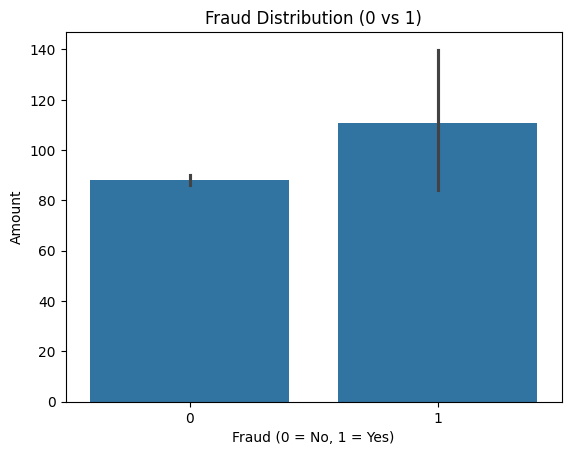

In [6]:
# exploratory visualization
sns.barplot(x='Fraud', y = 'Amount', data=fraud_train)

plt.title('Fraud Distribution (0 vs 1)')
plt.xlabel('Fraud (0 = No, 1 = Yes)')
plt.ylabel('Amount')
plt.show()

To explore the relationship between fraudulent transactions and the amount for these transactions, we created a barplot to show the distribution of fraud vs amount. It appears that fraudulent transactions (1=fraudulent) have a higher maximum amount value compared to non-fraudulent transactions. Due to the difference in distributions between fraudulent and non-fraudulent transactions, we see that there is evidence suggesting that there fraudulent transactions typically have higher amounts for their transactions.

### Models

In [7]:
# process data for ML
# helper function to print cross-validation results
def print_metric_scores(grid, metric):
    cv_results = grid.cv_results_
    best_index = grid.best_index_
    mean_score = cv_results[f"mean_test_{metric}"][best_index]
    std_score = cv_results[f"std_test_{metric}"][best_index]
    print(f"CV {metric} (mean ± std): {mean_score:.3f} ± {std_score:.3f}")

numeric_features = ['Amount']
target = 'Fraud'
#preprocessing for numerical features
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    #StandardScaler(),
)

#preprocessing for categorical features
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="infrequent_if_exist"),
)

# create general preprocessor
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    remainder="drop",
)

In [8]:
# train models
mod = DecisionTreeClassifier(random_state=42)
# weights for helping with imbalance
weights_list = [
    {0: 1, 1: 1},
    {0: 1, 1: 2},
    "balanced",
]

# define scoring metrics
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "recall": make_scorer(recall_score),
    "precision": make_scorer(precision_score, zero_division=0),
    "f1": make_scorer(fbeta_score, beta=1),
}

# define parameter grid
mod_param_grid = {
    "max_depth": [2,5,10],
    "class_weight": weights_list,
}

# setup grid search
mod_grid = GridSearchCV(
    mod,
    mod_param_grid,
    cv=5,
    scoring=scoring,
    refit="f1",
)

## Results

In [9]:
# report model metrics
# fit model specified by grid search
mod_grid.fit(X_train, y_train)

# print the best parameters and cross-validation metrics
print("")
print(f"Best parameters found with cross-validation:")
print(mod_grid.best_params_)
print("")
print_metric_scores(mod_grid, "accuracy")
print_metric_scores(mod_grid, "precision")
print_metric_scores(mod_grid, "recall")
print_metric_scores(mod_grid, "f1")

# make predictions on the test set using the best model
y_pred = mod_grid.predict(X_test)

# calculate test metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = fbeta_score(y_test, y_pred, beta=1)

# print test metrics
print("")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")


Best parameters found with cross-validation:
{'class_weight': {0: 1, 1: 2}, 'max_depth': 2}

CV accuracy (mean ± std): 0.998 ± 0.000
CV precision (mean ± std): 0.864 ± 0.054
CV recall (mean ± std): 0.819 ± 0.050
CV f1 (mean ± std): 0.839 ± 0.034

Test Accuracy: 0.9985997494288451
Test Precision: 0.9285714285714286
Test Recall: 0.8227848101265823
Test F1 Score: 0.87248322147651


After providing multiple weights and different max depth values for our Decision Tree model, we determined that the best model for this dataset with scores for a balance between recall, accuracy, precision, and f1beta to be a decision tree with max depth of 2 and using twice the weights for fraudulent transactions.

Our resulting test metrics are:

Test Accuracy: 0.9985997494288451

Test Precision: 0.9285714285714286

Test Recall: 0.8227848101265823

Test F1 Score: 0.87248322147651

In [10]:
# summary figure
cm = confusion_matrix(y_test, y_pred)

TN, FP, FN, TP = cm.ravel()

confusion_df = pd.DataFrame({
    'Metric': ['True Positive (TP)', 'True Negative (TN)', 'False Positive (FP)', 'False Negative (FN)'],
    'Count': [TP, TN, FP, FN]
})

print(confusion_df)


                Metric  Count
0   True Positive (TP)     65
1   True Negative (TN)  13485
2  False Positive (FP)      5
3  False Negative (FN)     14


To summarize our results, a confusion matrix was created to show how well our model can predict future fraudulent transactions. From the table output that is shown, we can see the true positive, true negative, false positive, and false negative counts of our predicted and actual fraudulent transactions. 

We would like to put more emphasis on creating a bigger coverage for fraudulent transactions since losing money and being notified of it is much more valuable than being notified of a false fraudulent report. It is better to be cautious and aware than unware of lost funds.

In regards to that concern, we can see that we have 14 false negatives out of 13,569 test observations. This means that we fail to detect 0.1% of transactions that are fraudulent out of all transactions. This is concerning because we should develop a model that covers more fraudulent transactions. Although the percentage is small, credit card transactions on the daily are numerous and will still have great gravity despite the small number of failed fraud detections.

In [11]:
# serialize model
from joblib import dump
dump(mod_grid, "fraud.joblib")

['fraud.joblib']

## Discussion

Despite fitting various weights and max depth values for our Decision Tree model, it is clear from our summary figure and analysis that we should not use this model. Credit card fraud is a very serious problem that can cause irreversible damage to the client if gone undetected. It is at the upmost importance that the bank can trace the scammer as soon as possible to recover funds. Based on our model's confusion matrix, we can see that we fail to detect 0.1% of fraudulent transactions out of all transactions. Like previously stated, although this percentage is small, the number of real life credit card transactions are many. The number of undetected fraudulent transactions, while using this model, will be much higher than expected.

In order to remedy this, we should increase the number of fraudulent transactions in our dataset (postives) so that the number of false negatives (undetected fraudulent transactions) decrease. It is not that concerning for a client to be notified incorrectly of a fraud than someone to not be notified at all and there is truly a fraudulent transaction occurring. The person in the situation prior would lose no money (just some sanity) while the other could be losing thousands if the bank fails to retrieve or identify the fraud.